In [39]:
#Dependencies
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time #may not be needed
import tweepy #pip install tweepy


#import vader sentiment intensity analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #pip install vaderSentiment
analyzer = SentimentIntensityAnalyzer()

#set authorization keys and secrets
#edit this out to keep keys secret and whatnot...
consumer_key = 'slkeKRpO4wPsytrmYu1EuDmdY'
consumer_secret =  'cm0rML2nllTdyjgMiJTCrL0FC7YmuskWotb1K12ltQ5imys6qJ'
access_token = '77581674-vJ8yVYXJq3K55L2IqzEaWyBjiD13ECnIjPanNZhw7'
access_token_secret =  'y69VBgQDKiBWGmOZYF61tpCsHAS5otcIrG1qmePyvAG6u'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)



In [40]:
#test: get example of tweepy output

testTweet = api.user_timeline('@BBC', count=1, result_type='recent')
for tweet in testTweet:
    test = tweet._json
    print(test['created_at'])

Mon Dec 11 20:00:06 +0000 2017


In [41]:
# *** Creating dataframe of tweet sentimentality and other twitter info. 
target = ['@BBC', '@CBS', '@CNN', '@FoxNews', '@nytimes']
newsMood_df = pd.DataFrame(columns = ['Handle', 'Compound Score', 'Positivity Score',\
                                      'Neutrality Score', 'Negativity Score'])

#loop through target users and get 100 most recent tweets from each
    #note: rate limit seems to be 900 requests every 15 mins
for user in target:
    user_ls = []
    compound_ls = []
    pos_ls = []
    neu_ls = []
    neg_ls = []
    time_ls = [] #time created 
    tweetsAgo_ls = [] # ranking of the latest tweet ( == the latest, 100 == 100th tweet in the past)
    counter = 0
    
    #test using 5 tweets first
    publicTweets = api.user_timeline(user, count=100, result_type="recent")
        #Should be sorted by latest tweets
        
    # loop through each tweet for a user 
    for tweet in publicTweets:
        # vader analyze sentiments for each tweet
        compound = analyzer.polarity_scores(tweet._json['text'])['compound']
        pos = analyzer.polarity_scores(tweet._json['text'])['pos']
        neu = analyzer.polarity_scores(tweet._json['text'])['neu']
        neg = analyzer.polarity_scores(tweet._json['text'])['neg']
        #get time tweet was posted
        time = tweet._json['created_at']
        #counter decrease by one
        counter -= 1
        
        # Add each value to the appropriate list
        #list of just the current user 
        user_ls.append(user)
        compound_ls.append(compound)
        pos_ls.append(pos)
        neu_ls.append(neu)
        neg_ls.append(neg)
        time_ls.append(time)
        tweetsAgo_ls.append(counter)
        
    # Create temporary dataframe to store those values    
    df = pd.DataFrame() 
    df['Handle'] = user_ls
    df['Timestamp'] = time_ls
    df['Compound Score'] = compound_ls
    df['Positivity Score'] = pos_ls
    df['Neutrality Score'] = neu_ls
    df['Negativity Score'] = neg_ls
    df['Tweets Ago'] = tweetsAgo_ls
    
    #append temp df to end of newsMood_df
    newsMood_df = newsMood_df.append(df)
        

df.head(20)

,Handle,Timestamp,Compound Score,Positivity Score,Neutrality Score,Negativity Score,Tweets Ago
0,@nytimes,Mon Dec 11 22:46:05 +0000 2017,-0.2023,0.000,0.930,0.070,-1
1,@nytimes,Mon Dec 11 22:31:04 +0000 2017,0.3400,0.130,0.870,0.000,-2
2,@nytimes,Mon Dec 11 22:15:12 +0000 2017,-0.2960,0.127,0.667,0.207,-3
3,@nytimes,Mon Dec 11 22:00:16 +0000 2017,0.8733,0.427,0.573,0.000,-4
4,@nytimes,Mon Dec 11 21:46:41 +0000 2017,0.2500,0.126,0.787,0.087,-5
5,@nytimes,Mon Dec 11 21:45:04 +0000 2017,0.6908,0.251,0.749,0.000,-6
6,@nytimes,Mon Dec 11 21:30:04 +0000 2017,0.4215,0.213,0.787,0.000,-7
7,@nytimes,Mon Dec 11 21:15:05 +0000 2017,0.0772,0.157,0.843,0.000,-8
8,@nytimes,Mon Dec 11 21:00:26 +0000 2017,0.2023,0.244,0.588,0.168,-9
9,@nytimes,Mon Dec 11 20:50:05 +0000 2017,-0.7506,0.109,0.484,0.407,-10


In [42]:
#data massage newsMood_df

#converts 'Timestamp' from string into datetime object
newsMood_df['Timestamp'] = pd.to_datetime(newsMood_df['Timestamp'])

# save newsMood_df to csv file in same folder
newsMood_df.to_csv('newsMood_dataframe.csv')

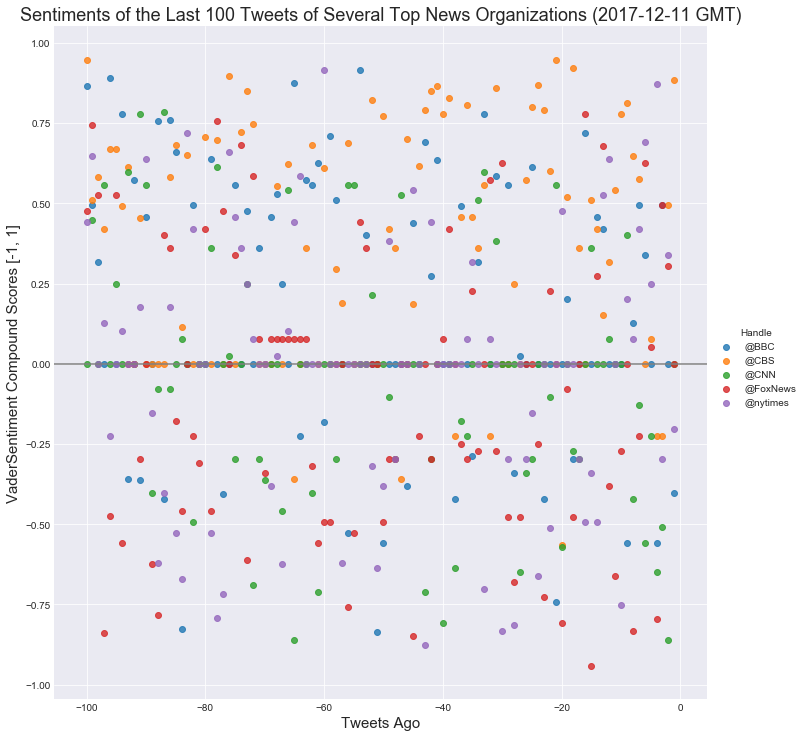

In [43]:
# *** Scatterplot of tweets and compound scores ***
sns.set_style('darkgrid')
sns.lmplot('Tweets Ago', 'Compound Score', data=newsMood_df, hue='Handle', size=10, fit_reg=False)

# Scatterplot labels
    # get date for use in title
latestTime = pd.Timestamp.now() #gets current time in current timezone
latestDate = latestTime.date() #gets the date from the current time  
plt.title('Sentiments of the Last 100 Tweets of Several Top News Organizations' + ' (' +\
          str(latestDate) + ' GMT)', fontsize=18)
# draw line at y=0
plt.axhline(0, color='grey')

#set fontsize
plt.xlabel('Tweets Ago', fontsize=15)
plt.ylabel('VaderSentiment Compound Scores [-1, 1]', fontsize=15)

#save as png file
fig.savefig('Sentiments_100Tweets_News_Orgs.png')
    
plt.show()
    

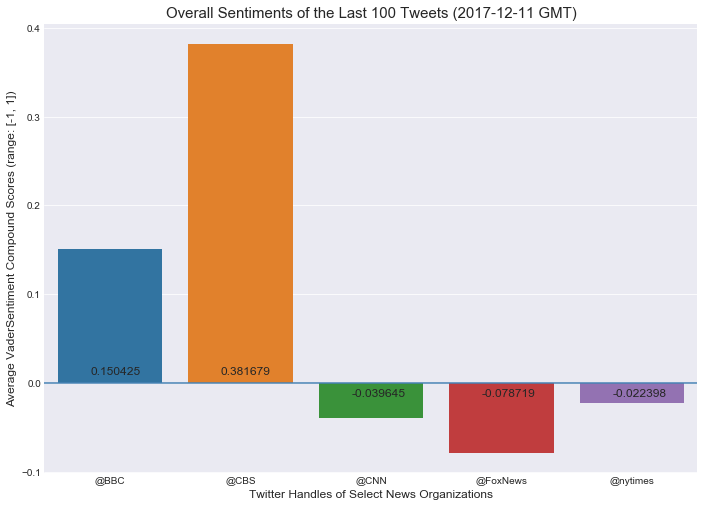

In [47]:
# *** Bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. ***

#group by twitter handles and the average values of each column
MoodAvgs_group = newsMood_df.groupby('Handle').mean()

#set fig size
fig, ax = plt.subplots()
    # the size of A4 paper
fig.set_size_inches(11.7, 8.27)

# Seaborn barplot 
sns.barplot(x=MoodAvgs_group.index , y='Compound Score' , data=MoodAvgs_group)

#add annotations for each graph
for p in ax.patches: # loops through each bar or "patch" I think
    if p.get_height() > 0:
        ax.annotate(str(p.get_height()), (p.get_x() + .25, 0.01), size=12)
    else:
        ax.annotate(str(p.get_height()), (p.get_x() + .25, -0.015), size=12)

# draw line at y=0
plt.axhline(0, color='steelblue')

# Create labels
plt.title('Overall Sentiments of the Last 100 Tweets' + ' (' + str(latestDate) + ' GMT)', fontsize = 15)
plt.xlabel('Twitter Handles of Select News Organizations', fontsize=12)
plt.ylabel('Average VaderSentiment Compound Scores (range: [-1, 1])', fontsize=12)

#save as png file
fig.savefig('Sentiments_OverallTweets_News_Orgs.png')

plt.show()